# First Poke

## Prepare training data
Training data will be a pandas dataframe grouped by dates. Each date will correspond to all the words of all the articles that day. 
1. TODO: How do we handle weekends? (May cause problems in continuos data)
2. TODO: Drop the days that do not have any articles.
3. TODO: lower case all data

In [1]:
import pickle
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../')
import datetime

In [2]:
%matplotlib inline

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import stock_data
import validation
from sklearn import preprocessing

In [4]:
with open("./sample_data1.pkl", "rb") as fp:   # Unpickling
    raw = pickle.load(fp)

In [5]:
df = pd.DataFrame(raw, columns = ["link", "time", "words"])

In [6]:
#Convert to date time type. Sort by date
df['time'] = pd.to_datetime(df.time)
df = df.sort_values('time')
df = df.set_index('time')

In [7]:
df.head()

,link,words
time,,
2018-09-27 00:31:19,https://www.nytimes.com/2018/09/26/sports/manc...,"[MANCHESTER, England, It, was, past, midnight,..."
2018-09-27 04:03:26,https://www.nytimes.com/2018/09/27/briefing/eu...,"[Want, to, get, this, briefing, by, email, Her..."
2018-09-27 04:41:51,https://www.nytimes.com/2018/09/27/world/austr...,"[The, Australia, Letter, is, a, weekly, newsle..."
2018-09-27 09:00:05,https://www.nytimes.com/2018/09/27/travel/how-...,"[When, looking, for, restaurant, recommendatio..."
2018-09-27 09:44:58,https://www.nytimes.com/2018/09/27/briefing/br...,"[Want, to, get, this, briefing, by, email, Her..."


In [8]:
# Collapse the weekend articles all onto Friday
df['dayofweek'] = df.index.dayofweek
df.loc[df.dayofweek == 5,  'index'] = df[df.dayofweek == 5].index - pd.Timedelta(days=1)
df.loc[df.dayofweek == 6, 'index'] = df[df.dayofweek == 6].index - pd.Timedelta(days=2)
df.loc[(df.dayofweek != 5) & (df.dayofweek != 6),  'index'] = df[(df.dayofweek != 5) & (df.dayofweek != 6)].index

In [9]:
df = df.set_index('index')
df.drop(columns = 'dayofweek', inplace = True)

In [10]:
# Weekends are now gotten rid of.
df[28:36]

,link,words
index,,
2018-09-28 20:33:28,https://www.nytimes.com/2018/09/28/books/revie...,"[Subscribe, iTunes, Google, Play, Music, How, ..."
2018-09-28 23:27:41,https://www.nytimes.com/2018/09/29/world/europ...,"[LONDON, The, British, telephone, box, is, not..."
2018-09-28 04:05:01,https://www.nytimes.com/2018/09/30/fashion/wed...,"[Stephanie, Audrey, Friedman, and, Stanley, Ga..."
2018-09-28 04:10:01,https://www.nytimes.com/2018/09/30/fashion/wed...,"[Jennifer, Yoosun, Berry, and, Travis, Shane, ..."
2018-09-28 04:30:02,https://www.nytimes.com/2018/09/30/fashion/wed...,"[Tiffany, Lynn, Jow, and, Wade, James, Michael..."
2018-09-28 20:36:34,https://www.nytimes.com/2018/09/30/business/me...,"[GLENDALE, Calif, A, young, actor, with, a, bu..."
2018-10-01 05:00:06,https://www.nytimes.com/2018/10/01/arts/televi...,"[A, new, sitcom, airs, on, CBS, while, a, new,..."
2018-10-01 11:08:25,https://www.nytimes.com/2018/10/01/business/de...,"[Good, Monday, Want, this, by, email, Sign, up..."


In [11]:
#Convert to String. Handle None type
df['liststring'] = [','.join(map(str, l)) if l is not None else "" for l in df['words'] ]
df.drop(columns= ['words'], inplace = True)

In [12]:
#Concat all the strings of a single day together
post_df = df.groupby(pd.Grouper(freq='D'))['liststring'].apply(lambda x: x.sum())

In [13]:
#Range of dates
print(post_df.head(1).index)
print(post_df.tail(1).index)

DatetimeIndex(['2018-09-27'], dtype='datetime64[ns]', name='index', freq='D')
DatetimeIndex(['2019-05-17'], dtype='datetime64[ns]', name='index', freq='D')


In [14]:
post_df.head()

index
2018-09-27    MANCHESTER,England,It,was,past,midnight,when,J...
2018-09-28    You,may,have,noticed,a,bold,advertisement,in,T...
2018-09-29                                                    0
2018-09-30                                                    0
2018-10-01    A,new,sitcom,airs,on,CBS,while,a,new,documenta...
Freq: D, Name: liststring, dtype: object

## Prepare labels (which is the stock data) 

In [15]:
#Get the stock data to use as our labels
label = stock_data.get_stock_data('GOOG', '94Z49Z19XNL1GGGP')

In [16]:
#Range of dates
print(label.head(1).index)
print(label.tail(1).index)

DatetimeIndex(['2014-03-27'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2019-06-04'], dtype='datetime64[ns]', name='date', freq=None)


In [17]:
#Truncate the date range to fit the post_df dataframe
label = label.truncate(before=pd.Timestamp('2018-09-27'), after=pd.Timestamp('2019-05-17'))

In [18]:
label.drop(columns=['ds'], inplace=True)
label.head(3)

,open,high,low,close,volume
date,,,,,
2018-09-27,1186.7300,1202.1000,1183.6300,1194.6400,1260754
2018-09-28,1191.8700,1195.4100,1184.5000,1193.4700,1380629
2018-10-01,1199.8900,1209.9000,1190.3000,1195.3100,1357604


This data doesn't have weekends. Need to think of some kind of way to handle this.

# Applying labels to article DataFrame

In [19]:
# Get days of the week
sdf = pd.DataFrame({'words': post_df})
sdf['dayofweek'] = sdf.index.dayofweek

# #Drop weekends
sdf = sdf[sdf.dayofweek != 5]
sdf = sdf[sdf.dayofweek != 6]
sdf.head()

,words,dayofweek
index,,
2018-09-27,"MANCHESTER,England,It,was,past,midnight,when,J...",3
2018-09-28,"You,may,have,noticed,a,bold,advertisement,in,T...",4
2018-10-01,"A,new,sitcom,airs,on,CBS,while,a,new,documenta...",0
2018-10-02,"Student,Athlete,a,documentary,with,LeBron,Jame...",1
2018-10-03,"Apple,opened,a,routine,product,launch,event,la...",2


In [20]:
# Label Days of week
label['dayofweek'] = label.index.dayofweek
label.drop(columns=['high', 'low', 'close', 'volume'], inplace=True)

In [21]:
# Shift dates back by 1 day, stored into column "last"
# Handle the unique case of Monday where the delta will be taken from Friday. Not Sunday.
label.loc[label.dayofweek == 0, 'last'] = label[label.dayofweek == 0].index - pd.Timedelta(days=3)
label.loc[label.dayofweek != 0, 'last'] = label[label.dayofweek != 0].index - pd.Timedelta(days=1)

In [22]:
label.head()

,open,dayofweek,last
date,,,
2018-09-27,1186.7300,3,2018-09-26
2018-09-28,1191.8700,4,2018-09-27
2018-10-01,1199.8900,0,2018-09-28
2018-10-02,1190.9600,1,2018-10-01
2018-10-03,1205.0000,2,2018-10-02


In [23]:
deltas = label.merge(label, left_on='last', right_on='date', suffixes=('_left', '_right'))

In [24]:
deltas.head()

,open_left,dayofweek_left,last_left,open_right,dayofweek_right,last_right
0,1191.8700,4,2018-09-27,1186.7300,3,2018-09-26
1,1199.8900,0,2018-09-28,1191.8700,4,2018-09-27
2,1190.9600,1,2018-10-01,1199.8900,0,2018-09-28
3,1205.0000,2,2018-10-02,1190.9600,1,2018-10-01
4,1195.3300,3,2018-10-03,1205.0000,2,2018-10-02


In [25]:
# Subtract the open prices between the merged "open" columns
deltas = label.merge(label, left_on='last', right_on='date', suffixes=('_left', '_right'))
deltas.rename({'open_left':'date'}, inplace=True)
deltas.set_index('last_left', drop=True, inplace=True)
deltas['delta'] = pd.to_numeric(deltas.open_left) - pd.to_numeric(deltas.open_right)
deltas.drop(columns=['open_left', 'open_right', 'last_right'], inplace=True)
display(deltas.shape)
deltas.head()

(152, 3)

,dayofweek_left,dayofweek_right,delta
last_left,,,
2018-09-27,4,3,5.14
2018-09-28,0,4,8.02
2018-10-01,1,0,-8.93
2018-10-02,2,1,14.04
2018-10-03,3,2,-9.67


In [26]:
# Join the delta data with the original df of article data
# proc_df = sdf.merge(label.drop(columns=['last']), how='outer', left_index=True, right_index=True)
# display(proc_df.head())
# display(proc_df.shape)
# proc_df.dtypes

In [27]:
proc_df = sdf
proc_df['delta'] = deltas.delta

In [28]:
proc_df.head()

,words,dayofweek,delta
index,,,
2018-09-27,"MANCHESTER,England,It,was,past,midnight,when,J...",3,5.14
2018-09-28,"You,may,have,noticed,a,bold,advertisement,in,T...",4,8.02
2018-10-01,"A,new,sitcom,airs,on,CBS,while,a,new,documenta...",0,-8.93
2018-10-02,"Student,Athlete,a,documentary,with,LeBron,Jame...",1,14.04
2018-10-03,"Apple,opened,a,routine,product,launch,event,la...",2,-9.67


In [29]:
# Check if there are weekends
proc_df[(proc_df.dayofweek == 5) | (proc_df.dayofweek == 6)].any()

words        False
dayofweek    False
delta        False
dtype: bool

No weekends found. Good.

In [30]:
# Check for null and NA values
null_columns = proc_df.columns[proc_df.isnull().any()]
na_columns = proc_df.columns[proc_df.isna().any()]
print("Check for null:")
print(proc_df[null_columns].isnull().sum())
print("-----------------------------------")
print("Check for na:")
print(proc_df[na_columns].isna().sum())

Check for null:
delta    15
dtype: int64
-----------------------------------
Check for na:
delta    15
dtype: int64


Most likely the same 15.

In [31]:
proc_df = proc_df.dropna()

In [32]:
# Check for null and NA values
null_columns = proc_df.columns[proc_df.isnull().any()]
na_columns = proc_df.columns[proc_df.isna().any()]
print("Check for null:")
print(proc_df[null_columns].isnull().sum())
print("-----------------------------------")
print("Check for na:")
print(proc_df[na_columns].isna().sum())

Check for null:
Series([], dtype: float64)
-----------------------------------
Check for na:
Series([], dtype: float64)


In [33]:
# Make sure all the strings are lower cased
proc_df['words'] = proc_df['words'].str.lower()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
proc_df.head()

,words,dayofweek,delta
index,,,
2018-09-27,"manchester,england,it,was,past,midnight,when,j...",3,5.14
2018-09-28,"you,may,have,noticed,a,bold,advertisement,in,t...",4,8.02
2018-10-01,"a,new,sitcom,airs,on,cbs,while,a,new,documenta...",0,-8.93
2018-10-02,"student,athlete,a,documentary,with,lebron,jame...",1,14.04
2018-10-03,"apple,opened,a,routine,product,launch,event,la...",2,-9.67


## Just testing some stuff out

In [35]:
sid = SentimentIntensityAnalyzer()

In [36]:
def get_rule_sentiment(words):
    return validation.get_rule_sentiment(words.split(' '))

In [37]:
def get_nltk_sentiment(words):
    cc = sid.polarity_scores(words)
    return (cc['compound'])

In [38]:
# Save the data frame to use for TFIDF (another notebook)
proc_df.to_pickle('./proc_df.pkl')

In [39]:
proc_df['rule_score'] = proc_df['words'].map(lambda x : get_rule_sentiment(x.replace(',', ' ')))
proc_df['nltk_compound'] = proc_df['words'].map(lambda x : get_nltk_sentiment(x.replace(',', ' ')))
proc_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,words,dayofweek,delta,rule_score,nltk_compound
index,,,,,
2018-09-27,"manchester,england,it,was,past,midnight,when,j...",3,5.14,430,0.9998
2018-09-28,"you,may,have,noticed,a,bold,advertisement,in,t...",4,8.02,578,1.0000
2018-10-01,"a,new,sitcom,airs,on,cbs,while,a,new,documenta...",0,-8.93,76,0.9986
2018-10-02,"student,athlete,a,documentary,with,lebron,jame...",1,14.04,249,0.9998
2018-10-03,"apple,opened,a,routine,product,launch,event,la...",2,-9.67,283,0.9999


## Test for previous models (Rule_score & NLTK)

#### Normalize

In [40]:
x = proc_df[['rule_score', 'nltk_compound', 'delta']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)

In [41]:
data.rename(columns = {0: "rule_score", 1: "ntlk_compound", 2: 'delta'}, inplace= True)

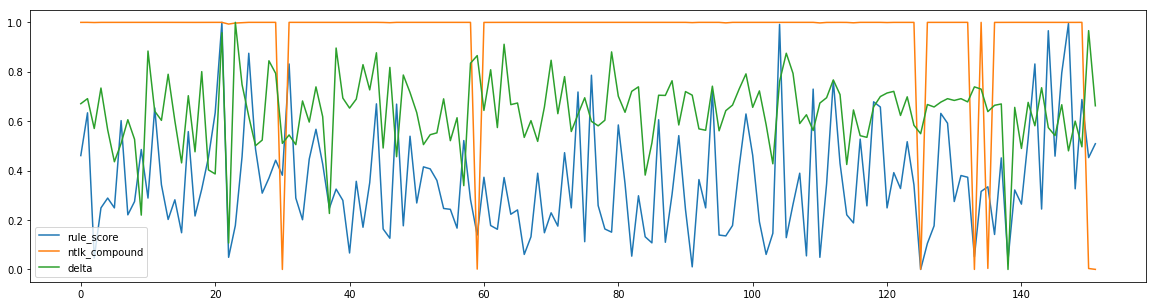

In [42]:
data.plot(figsize=(20, 5))

In [43]:
from sklearn.metrics import mean_squared_error
def get_mean_sq_error(data):
    """
    Given a pd DataFrame of 'rule_score', 'nltk_compound', 'delta'
    Return a dictionary of the accuracy scores for each.
    """
    rule = mean_squared_error(data['rule_score'], data['delta'])
    nltk = mean_squared_error(data['ntlk_compound'], data['delta'])
    return {'msq_rule': rule, 'msq_nltk': nltk}
get_mean_sq_error(data)

{'msq_rule': 0.14684748529200484, 'msq_nltk': 0.1706233505221293}

## Try out a different normalizing method

In [44]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_scaled2 = scale.fit_transform(x.values)
data2 = pd.DataFrame(x_scaled2)

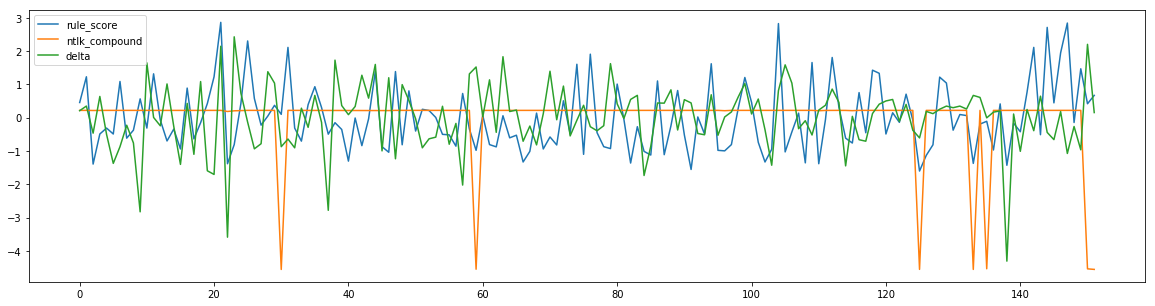

In [45]:
data2.rename(columns = {0: "rule_score", 1: "ntlk_compound", 2: 'delta'}, inplace= True)
data2.plot(figsize=(20, 5))

In [46]:
get_mean_sq_error(data2)

{'msq_rule': 1.8756499873978094, 'msq_nltk': 2.1914663772786134}

In [47]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0)
x_scaled3 = qt.fit_transform(x.values)
data3 = pd.DataFrame(x_scaled3)

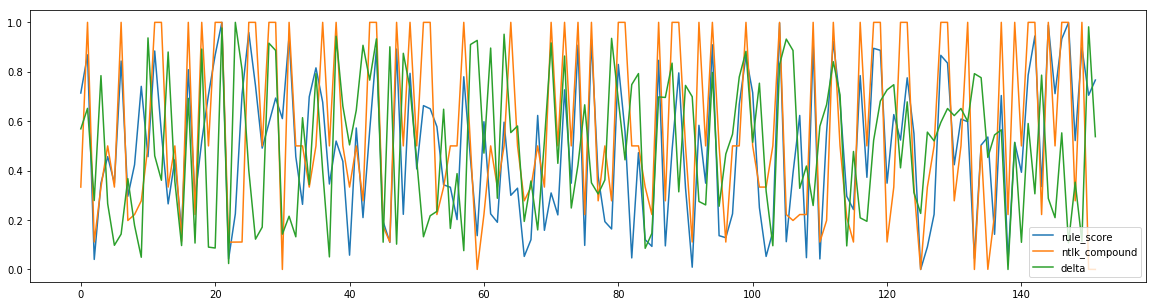

In [48]:
data3.rename(columns = {0: "rule_score", 1: "ntlk_compound", 2: 'delta'}, inplace= True)
data3.plot(figsize=(20, 5))

In [49]:
get_mean_sq_error(data3)

{'msq_rule': 0.15897853965141165, 'msq_nltk': 0.19642822765202023}